## Computing the Average Possessions per Minute for all Teams in the last 20 seasons.

Using the NBA API to obtain the amount of possessions and minutes played by all teams in the NBA during the last 20 seasons.

Plotting with [Plotly Express](https://plotly.com/python/plotly-express/)

In [109]:
# All needed imports
from nba_api.stats.endpoints import leaguedashteamstats
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import time

In [110]:
# Get teams possessions and minutes played for last 20 seasons
# API doesn't let us obtain for information for the 20 years, we have to call this 20 times
df = pd.DataFrame()
for i in range(20):
    # Building the Season String (ie. 2020-21)
    season_str = f"{2001 + i}-{2 + i:02d}"
    # Let's make some attempts to obtain the data, since we might be doing too many requests...
    for attempt in range(5):
        try:
            # Try to get the information for the season, getting only the columns we need
            teams = leaguedashteamstats.LeagueDashTeamStats(
                season=season_str, measure_type_detailed_defense="Advanced",
            ).get_data_frames()[0][["TEAM_ID", "TEAM_NAME", "MIN", "POSS"]]
        except:
            # If we get an error we go to sleep for some time
            time.sleep(30)
        else:
            # If everything's OK with the request, we continue
            break

    if len(teams):
        teams["SEASON"] = 2002 + i
        df = pd.concat([df, teams], axis=0)
    else:
        print("Try again :(")
        break

df.head()

,TEAM_ID,TEAM_NAME,MIN,POSS,SEASON
0,1610612737,Atlanta Hawks,3956.0,7678,2002
1,1610612738,Boston Celtics,3966.0,7738,2002
2,1610612766,Charlotte Hornets,3951.0,7480,2002
3,1610612741,Chicago Bulls,3961.0,7549,2002
4,1610612739,Cleveland Cavaliers,3971.0,7553,2002


In [111]:
# Get possessions per minute for every row.
df["POSS_PER_MIN"] = df["POSS"] / df["MIN"]

In [112]:
# Get the average possessions per minute for the league in each season.
poss_per_min_series = df.groupby("SEASON")["POSS_PER_MIN"].mean()
poss_per_min_df = pd.DataFrame(poss_per_min_series)
# Transform the index


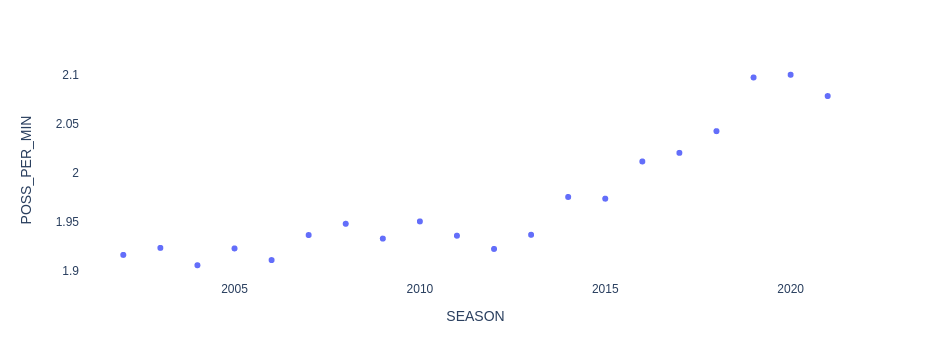

In [113]:
# Plot
fig = px.scatter(poss_per_min_df, x=poss_per_min_df.index, y=poss_per_min_df["POSS_PER_MIN"])
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)
fig.show()

## Boxplots
We can get a better visualization (not only averages) by using boxplots. Let's get the color for each team from [teamcolorcodes.com](https://teamcolorcodes.com/nba-team-color-codes/), there is a script that does this but we also store the information in a CSV file.

In [120]:
team_colors = pd.read_csv("team_colors.csv")
team_colors.head()

,team,color,border_color
0,Atlanta Hawks,#E03A3E,#C1D32F
1,Boston Celtics,#007a33,#BA9653
2,Brooklyn Nets,#000,#000
3,Charlotte Hornets,#1D1160,#00788c
4,Chicago Bulls,#CE1141,#000


We have different amounts of teams on each DF (due to name changes in the last years), we will need to make some arrangements.

In [124]:
df["TEAM_NAME"].nunique(), team_colors["team"].nunique()

(36, 31)

In [126]:
df["TEAM_NAME"].unique()

array(['Atlanta Hawks', 'Boston Celtics', 'Charlotte Hornets',
       'Chicago Bulls', 'Cleveland Cavaliers', 'Dallas Mavericks',
       'Denver Nuggets', 'Detroit Pistons', 'Golden State Warriors',
       'Houston Rockets', 'Indiana Pacers', 'Los Angeles Clippers',
       'Los Angeles Lakers', 'Memphis Grizzlies', 'Miami Heat',
       'Milwaukee Bucks', 'Minnesota Timberwolves', 'New Jersey Nets',
       'New York Knicks', 'Orlando Magic', 'Philadelphia 76ers',
       'Phoenix Suns', 'Portland Trail Blazers', 'Sacramento Kings',
       'San Antonio Spurs', 'Seattle SuperSonics', 'Toronto Raptors',
       'Utah Jazz', 'Washington Wizards', 'New Orleans Hornets',
       'Charlotte Bobcats', 'New Orleans/Oklahoma City Hornets',
       'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans',
       'LA Clippers'], dtype=object)

In [127]:
df.replace({
    "LA Clippers": "Los Angeles Clippers",
    "Charlotte Bobcats": "Charlotte Hornets",
    "New Orleans Hornets": "New Orleans Pelicans",
    "New Orleans/Oklahoma City Hornets": "New Orleans Pelicans",
    "New Jersey Nets": "Brooklyn Nets",
}, inplace=True)
team_colors.replace({"Seattle Supersonics": "Seattle SuperSonics"}, inplace=True)
print(df["TEAM_NAME"].nunique(), team_colors["team"].nunique())

31 31


We now have 31 teams (we will give the SuperSonics their chance to appear).
Let's merge the 2 DFs

In [132]:
df = df.merge(team_colors, left_on="TEAM_NAME", right_on="team")

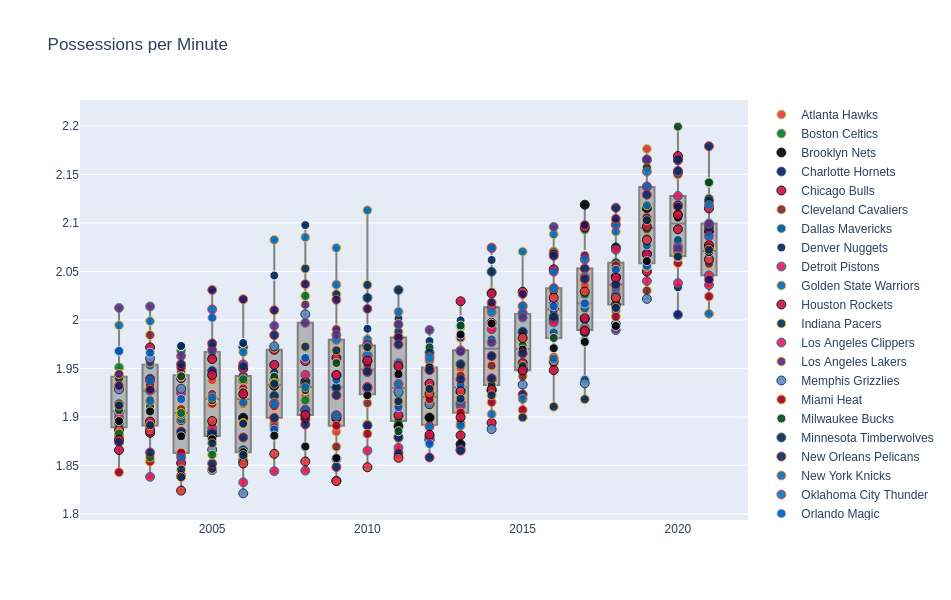

In [163]:
points = [
    go.Scatter(
        x=group["SEASON"], y=group["POSS_PER_MIN"], mode="markers", 
        # Getting the marker to look like the team with border color and color.
        marker=dict(opacity=0.9, size=9, line=dict(width=1, color=group["border_color"].iloc[0])),
        marker_color=group["color"].iloc[0], hoverinfo="name+y",
        text=name, name=name, showlegend=True,
    ) for name, group in df.groupby("TEAM_NAME")
]
fig = go.Figure(data=[
    go.Box(x=df["SEASON"], y=df["POSS_PER_MIN"], boxpoints=False, marker_color="lightgrey", line_color="grey", showlegend=False),
] + points)
fig.update_layout(title="Possessions per Minute", height=600)                    
fig.show()

### Conclusions
We can see that the playing pace has increased from the 2015 season and on, but the big leap is done in the 2018 season, since the minimum pace is a lot higher than in the 2017 season (almost the average on that year).